<a href="https://colab.research.google.com/github/kevin-r-murphy/BA888-MBTA/blob/main/MBTA_Bus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
trips = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/trips.txt')
shapes = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/shapes.txt')
stop_times = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/stop_times.txt')
stops = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/stops.txt')
route_patterns = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/route_patterns.txt')
route = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/routes.txt')
jan_headway = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/2024-01_Headway.csv')
feb_headway = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/2024-02_Headway.csv')
gated_entries = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/MBTA_Gated_Station_Entries.csv')
headways = pd.concat([jan_headway, feb_headway])

<ipython-input-2-1523b102d7d4>:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/trips.txt')
<ipython-input-2-1523b102d7d4>:5: DtypeWarning: Columns (0,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/stop_times.txt')
<ipython-input-2-1523b102d7d4>:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  jan_headway = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/2024-01_Headway.csv')
<ipython-input-2-1523b102d7d4>:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  feb_headway = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/2024-02_Headway.csv')


In [3]:
!pip install requests
import requests
import zipfile
from zipfile import ZipFile
import os, os.path

In [4]:
url = 'https://www.arcgis.com/sharing/rest/content/items/96c77138c3144906bce93d0257531b6a/data'
response = requests.get(url)
with open('Bus.zip', 'wb') as f:
    f.write(response.content)

with ZipFile('Bus.zip', 'r') as f:
    f.extractall()

In [5]:
bus_headways = pd.read_csv('/content/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-01.csv')
path = '/content/MBTA_Bus_Arrival_Departure_Times_2024'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
for i in range(2, num_files+1):
  df = pd.read_csv(f'/content/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-'+ str(i).zfill(2) + '.csv')
  bus_headways = pd.concat([bus_headways, df])

In [6]:
stop_times['stop_id'] = stop_times['stop_id'].astype(str)
stops['stop_id'] = stops['stop_id'].astype(str)
stop_times = stop_times.merge(stops, how = 'left', on = 'stop_id')

In [7]:
trips['route_id'] = trips['route_id'].astype(str)
trips['trip_id'] = trips['trip_id'].astype(str)
stop_times['trip_id'] = stop_times['trip_id'].astype(str)
trips = trips.merge(route[['route_id','route_desc', 'route_type']], how = 'left', on = 'route_id')

In [8]:
stop_times = stop_times.merge(trips[['trip_id','route_desc', 'route_type', 'route_id']], how = 'left', on = 'trip_id')

****Bus Data****

In [9]:
td = dt.timedelta(days=1)
bus_headways = bus_headways[bus_headways['scheduled'] != '1900-01-01']
bus_headways['scheduled'] = bus_headways['scheduled'].astype(str).apply(lambda x: x.split('T')[1].replace('Z','') if pd.notna(x) and 'T' in x else x)
bus_headways['scheduled'] = pd.to_datetime(bus_headways['scheduled'], format = "%H:%M:%S")
bus_headways['actual'] = bus_headways['actual'].astype(str).apply(lambda x: x.split('T')[1].replace('Z','') if pd.notna(x) and 'T' in x else x)
bus_headways['actual'] = pd.to_datetime(bus_headways['actual'], format = "%H:%M:%S")
bus_headways['actual'] = bus_headways['actual'].apply(lambda x: x + td if x < pd.Timestamp('1900-01-01 02:30:00') else x)
bus_headways['scheduled'] = bus_headways['scheduled'].apply(lambda x: x + td if x < pd.Timestamp('1900-01-01 02:30:00') else x)
bus_headways['time_diff'] = abs((bus_headways['actual'] - bus_headways['scheduled']).dt.total_seconds()) / 60
bus_headways['headway_diff'] = (bus_headways['headway'] - bus_headways['scheduled_headway']) / 60
bus_headways = bus_headways[bus_headways['time_diff'] < 1200]
bus_headways['half_trip_id'] = bus_headways['half_trip_id'].astype(str).apply(lambda x: x.split('.')[0])
bus_headways['scheduled_time'] = bus_headways['scheduled'].dt.time
bus_headways.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway,time_diff,headway_diff,scheduled_time
0,2024-01-01,01,Inbound,61824022,110,hhgat,1,Startpoint,Schedule,1900-01-01 06:05:00,1900-01-01 06:05:03,NaN,NaN,0.050000,NaN,06:05:00
1,2024-01-01,01,Inbound,61824022,67,maput,2,Midpoint,Schedule,1900-01-01 06:09:00,1900-01-01 06:08:17,NaN,NaN,0.716667,NaN,06:09:00
2,2024-01-01,01,Inbound,61824022,72,cntsq,3,Midpoint,Schedule,1900-01-01 06:12:00,1900-01-01 06:12:00,NaN,NaN,0.000000,NaN,06:12:00
3,2024-01-01,01,Inbound,61824022,75,mit,4,Midpoint,Schedule,1900-01-01 06:15:00,1900-01-01 06:16:50,NaN,NaN,1.833333,NaN,06:15:00
4,2024-01-01,01,Inbound,61824022,79,hynes,5,Midpoint,Schedule,1900-01-01 06:19:00,1900-01-01 06:20:45,NaN,NaN,1.750000,NaN,06:19:00


In [10]:
bus_headways['stop_id'] = bus_headways['stop_id'].astype(str)
bus_headways_stop = bus_headways.merge(stops[['stop_id','stop_name', 'stop_lat', 'stop_lon']], left_on = 'stop_id', right_on = 'stop_id', how = 'left')
bus_headways_stop = bus_headways_stop[bus_headways_stop['scheduled'] != '1899-12-31']
bus_standard_schedule = bus_headways_stop[bus_headways_stop['standard_type'] == 'Schedule']
bus_standard_headway = bus_headways_stop[bus_headways_stop['standard_type'] == 'Headway']
bus_standard_headway['headway_diff'] = bus_standard_headway['headway_diff'].apply(lambda x: 0 if x < 0 else x)
bus_standard_schedule.head()
print(bus_standard_schedule.shape)
print(bus_standard_headway.shape)

(6792585, 19)
(5573576, 19)


<ipython-input-10-2adf87d6b41c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_standard_headway['headway_diff'] = bus_standard_headway['headway_diff'].apply(lambda x: 0 if x < 0 else x)


***Bus - Schedule***

In [11]:
bus_standard_schedule.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway,time_diff,headway_diff,scheduled_time,stop_name,stop_lat,stop_lon
0,2024-01-01,01,Inbound,61824022,110,hhgat,1,Startpoint,Schedule,1900-01-01 06:05:00,1900-01-01 06:05:03,NaN,NaN,0.050000,NaN,06:05:00,Massachusetts Ave @ Holyoke St,42.373111,-71.117653
1,2024-01-01,01,Inbound,61824022,67,maput,2,Midpoint,Schedule,1900-01-01 06:09:00,1900-01-01 06:08:17,NaN,NaN,0.716667,NaN,06:09:00,Mt Auburn St @ Putnam Ave,42.370044,-71.113514
2,2024-01-01,01,Inbound,61824022,72,cntsq,3,Midpoint,Schedule,1900-01-01 06:12:00,1900-01-01 06:12:00,NaN,NaN,0.000000,NaN,06:12:00,Massachusetts Ave @ Pearl St,42.364915,-71.103074
3,2024-01-01,01,Inbound,61824022,75,mit,4,Midpoint,Schedule,1900-01-01 06:15:00,1900-01-01 06:16:50,NaN,NaN,1.833333,NaN,06:15:00,84 Massachusetts Ave,42.358673,-71.093551
4,2024-01-01,01,Inbound,61824022,79,hynes,5,Midpoint,Schedule,1900-01-01 06:19:00,1900-01-01 06:20:45,NaN,NaN,1.750000,NaN,06:19:00,Massachusetts Ave @ Boylston St,42.346965,-71.087720


Text(0, 0.5, 'Average Departure Difference (Minutes)')

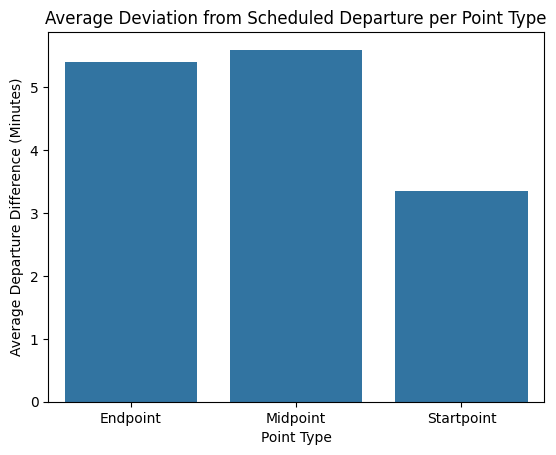

In [12]:
sns.barplot(bus_standard_schedule.groupby('point_type')['time_diff'].mean())
plt.title('Average Deviation from Scheduled Departure per Point Type')
plt.xlabel('Point Type')
plt.ylabel('Average Departure Difference (Minutes)')

**Aggregated DataFrames for Scheduled Bus**

In [13]:
#Creating Aggregated Dataframes for enhanced views
bus_schedule_station = bus_standard_schedule.groupby(['stop_id','direction_id', 'stop_name', 'stop_lat', 'stop_lon'])['time_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_schedule_station = bus_schedule_station.sort_values(by = 'median', ascending = False)
bus_schedule_station['stop_title'] = bus_schedule_station['stop_name'] + ' ' + bus_schedule_station['direction_id'].astype(str)
bus_schedule_station= bus_schedule_station[bus_schedule_station['count'] > 20]
bus_schedule_station.head()


,stop_id,direction_id,stop_name,stop_lat,stop_lon,mean,median,std,max,min,count,stop_title
982,5862,Outbound,Opp 345 Maverick St,42.366524,-71.030532,28.741304,29.350000,10.161993,46.766667,4.366667,23,Opp 345 Maverick St Outbound
969,57400,Outbound,Maverick,42.369070,-71.039473,27.013426,27.408333,11.286567,49.983333,0.350000,36,Maverick Outbound
341,20,Inbound,Dorchester St @ E Broadway,42.335377,-71.045728,12.266517,12.433333,5.764770,29.800000,0.450000,111,Dorchester St @ E Broadway Inbound
2,10006,Inbound,Albany St opp E Newton St,42.335814,-71.070135,14.620320,12.416667,11.218661,326.366667,0.000000,6232,Albany St opp E Newton St Inbound
283,1780,Inbound,Longwood Ave @ Blackfan St,42.337436,-71.104448,14.175577,12.400000,9.303878,87.533333,0.066667,2645,Longwood Ave @ Blackfan St Inbound


Text(0.5, 0, 'Median Departure Difference (Minutes)')

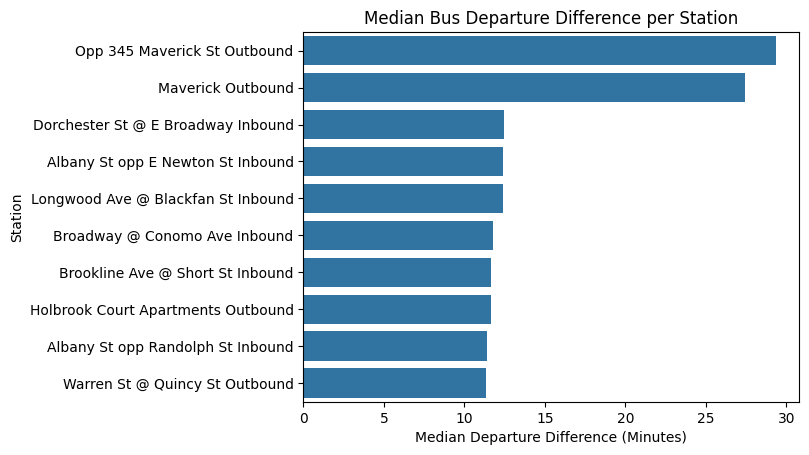

In [14]:
sns.barplot(data = bus_schedule_station.head(10), x = 'median', y = 'stop_title', orient = 'h')
plt.title('Median Bus Departure Difference per Station')
plt.ylabel('Station')
plt.xlabel('Median Departure Difference (Minutes)')

In [15]:
import plotly.express as px
from plotly.offline import plot
px.set_mapbox_access_token('pk.eyJ1Ijoia2VtdTEiLCJhIjoiY2x5YWYzeDZtMTNwdzJybXhsMnhiOHFlcCJ9.ZlVG4dJl_SlRlFhYPmQdsw')
fig = px.scatter_mapbox(bus_schedule_station.head(100), lat="stop_lat", lon="stop_lon",
                        zoom=10,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station - Arrival',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop'},
                        hover_data = ['direction_id', 'stop_name'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)

fig.show()

In [16]:
bus_schedule_route = bus_standard_schedule.groupby(['route_id', 'direction_id'])['time_diff'].agg(['mean', 'median','std', 'max', 'min','count']).reset_index()
bus_schedule_route['route_name'] = bus_schedule_route['route_id'] + ' ' + bus_schedule_route['direction_id'].astype(str)
bus_schedule_route = bus_schedule_route.merge(route[['route_id', 'route_long_name', 'route_desc']])
bus_schedule_route = bus_schedule_route.sort_values(by = 'median', ascending = False)
bus_schedule_route.head()

,route_id,direction_id,mean,median,std,max,min,count,route_name,route_long_name,route_desc
173,47,Inbound,10.958036,8.233333,10.585401,331.100000,0.0,48106,47 Inbound,"Central Square, Cambridge - Broadway Station",Local Bus
101,29,Inbound,10.314449,7.716667,8.628204,83.466667,0.0,25632,29 Inbound,Mattapan Station - Jackson Square Station,Local Bus
96,245,Outbound,10.605902,7.583333,10.159615,66.283333,0.0,4744,245 Outbound,Quincy Center Station - Mattapan Station,Local Bus
140,424,Outbound,8.468626,7.283333,6.475482,56.616667,0.0,4390,424 Outbound,Eastern Avenue & Essex Street - Wonderland Sta...,Commuter Bus
102,29,Outbound,9.969110,7.166667,9.205833,73.366667,0.0,23962,29 Outbound,Mattapan Station - Jackson Square Station,Local Bus


Text(0.5, 0, 'Median Departure Difference (Minutes)')

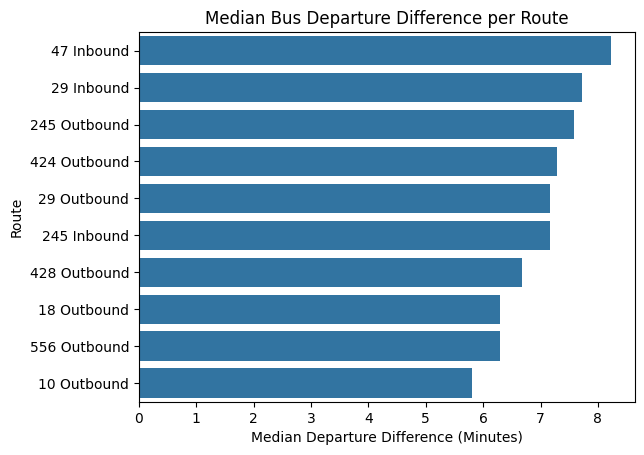

In [17]:
sns.barplot(data = bus_schedule_route.head(10), x = 'median', y = 'route_name', orient = 'h')
plt.title('Median Bus Departure Difference per Route')
plt.ylabel('Route')
plt.xlabel('Median Departure Difference (Minutes)')

In [18]:
bus_schedule_route_stop = bus_standard_schedule.groupby(['route_id', 'direction_id', 'stop_id', 'stop_name', 'stop_lat', 'stop_lon'])['time_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_schedule_route_stop = bus_schedule_route_stop.sort_values(by = 'median', ascending = False)
bus_schedule_route_stop['route_name'] = 'Route: ' + bus_schedule_route_stop['route_id'] + ' ' + bus_schedule_route_stop['direction_id'].astype(str) + ' At ' + bus_schedule_route_stop['stop_name']
bus_schedule_route_stop.head()

,route_id,direction_id,stop_id,stop_name,stop_lat,stop_lon,mean,median,std,max,min,count,route_name
678,210,Outbound,38671,Braintree,42.207213,-71.001278,53.966667,53.966667,NaN,53.966667,53.966667,1,Route: 210 Outbound At Braintree
679,210,Outbound,41031,Quincy Adams,42.233238,-71.007244,49.466667,49.466667,NaN,49.466667,49.466667,1,Route: 210 Outbound At Quincy Adams
1611,45,Outbound,334,Ashmont,42.284195,-71.063879,31.270303,31.033333,8.676351,54.350000,14.200000,110,Route: 45 Outbound At Ashmont
1614,45,Outbound,426,Talbot Ave @ Lithgow St,42.289943,-71.069975,31.224943,30.716667,8.065374,52.566667,14.566667,147,Route: 45 Outbound At Talbot Ave @ Lithgow St
1612,45,Outbound,415,Blue Hill Ave @ Franklin Park Rd,42.303293,-71.085370,30.971581,30.583333,9.090911,60.700000,12.350000,156,Route: 45 Outbound At Blue Hill Ave @ Franklin...


Text(0.5, 0, 'Median Departure Difference (Minutes)')

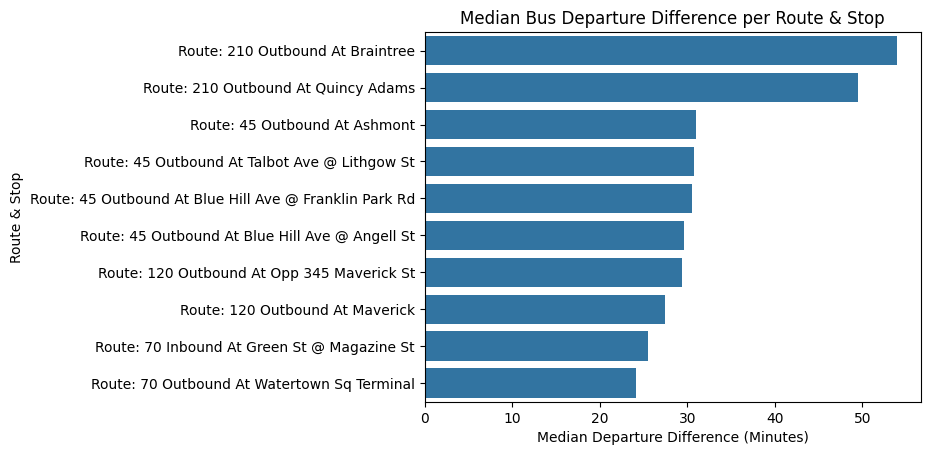

In [19]:
sns.barplot(data = bus_schedule_route_stop.head(10), x = 'median', y = 'route_name', orient = 'h')
plt.title('Median Bus Departure Difference per Route & Stop')
plt.ylabel('Route & Stop')
plt.xlabel('Median Departure Difference (Minutes)')

In [20]:
fig = px.scatter_mapbox(bus_schedule_route_stop.head(100), lat="stop_lat", lon="stop_lon",
                        zoom=10,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station & Route - Schedule',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop',
                                  'route_id': 'Route'},
                        hover_data = ['direction_id', 'stop_name', 'route_id'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)

fig.show()

In [21]:
bus_schedule_date = bus_standard_schedule.groupby(['service_date', 'direction_id'])['headway_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_schedule_date = bus_schedule_date.sort_values(by = 'median', ascending = False)
bus_schedule_date['date_name'] = bus_schedule_date['service_date'] + ' ' + bus_schedule_date['direction_id'].astype(str)
bus_schedule_date.head()

,service_date,direction_id,mean,median,std,max,min,count,date_name
0,2024-01-01,Inbound,NaN,NaN,NaN,NaN,NaN,0,2024-01-01 Inbound
1,2024-01-01,Outbound,NaN,NaN,NaN,NaN,NaN,0,2024-01-01 Outbound
2,2024-01-02,Inbound,NaN,NaN,NaN,NaN,NaN,0,2024-01-02 Inbound
3,2024-01-02,Outbound,NaN,NaN,NaN,NaN,NaN,0,2024-01-02 Outbound
4,2024-01-03,Inbound,NaN,NaN,NaN,NaN,NaN,0,2024-01-03 Inbound


**Aggregated DataFrames for Headway Bus**

In [22]:
bus_headway_station = bus_standard_headway.groupby(['stop_id','direction_id', 'stop_name', 'stop_lat', 'stop_lon'])['headway_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_headway_station = bus_headway_station.sort_values(by = 'median', ascending = False)
bus_headway_station['stop_title'] = bus_headway_station['stop_name'] + ' ' + bus_headway_station['direction_id'].astype(str)
bus_headway_station.head()

,stop_id,direction_id,stop_name,stop_lat,stop_lon,mean,median,std,max,min,count,stop_title
324,4165,Outbound,N Main St @ Scanlon Dr,42.201227,-71.062850,11.288194,9.483333,11.504215,46.566667,0.0,24,N Main St @ Scanlon Dr Outbound
446,5790,Outbound,49 Central Ave,42.409605,-71.010465,10.452703,8.816667,9.574476,51.366667,0.0,74,49 Central Ave Outbound
325,4177,Outbound,N Main St opp Francis Dr,42.183170,-71.053734,10.974638,8.800000,11.772203,46.316667,0.0,23,N Main St opp Francis Dr Outbound
323,4153,Outbound,Randolph Ave @ Reedsdale Rd,42.248410,-71.069317,11.050694,8.591667,11.768437,46.450000,0.0,24,Randolph Ave @ Reedsdale Rd Outbound
336,45002,Outbound,Medford Sq @ City Hall Parking lot,42.417653,-71.106038,13.574074,8.333333,13.732365,34.350000,0.0,9,Medford Sq @ City Hall Parking lot Outbound


Text(0.5, 0, 'Median Headway Difference (Minutes)')

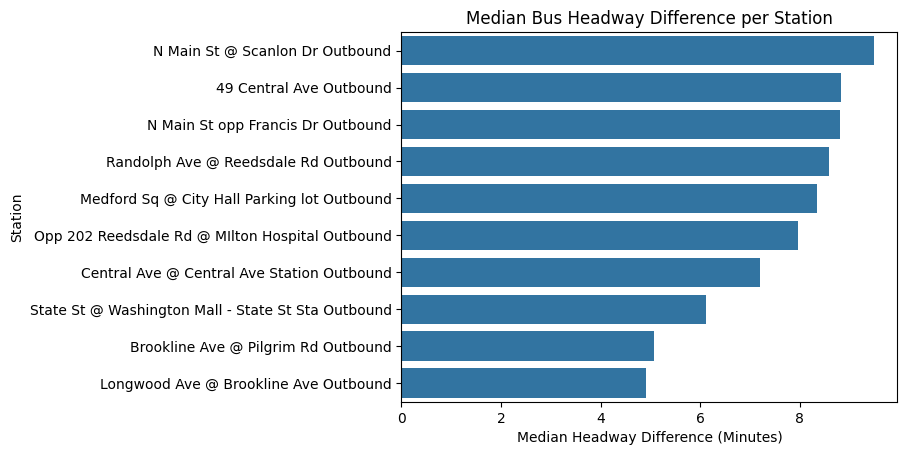

In [23]:
sns.barplot(data = bus_headway_station.head(10), x = 'median', y = 'stop_title', orient = 'h')
plt.title('Median Bus Headway Difference per Station')
plt.ylabel('Station')
plt.xlabel('Median Headway Difference (Minutes)')

In [24]:
fig = px.scatter_mapbox(bus_headway_station, lat="stop_lat", lon="stop_lon",
                        zoom=10,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station - Headway',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop'},
                        hover_data = ['direction_id', 'stop_name'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)

fig.show()

In [25]:
bus_headway_route = bus_standard_headway.groupby(['route_id', 'direction_id'])['headway_diff'].agg(['mean', 'median','std', 'max', 'min','count']).reset_index()
bus_headway_route['route_name'] = bus_headway_route['route_id'] + ' ' + bus_headway_route['direction_id'].astype(str)
bus_headway_route = bus_headway_route.merge(route[['route_id', 'route_long_name', 'route_desc']])
bus_headway_route = bus_headway_route.sort_values(by = 'median', ascending = False)
bus_headway_route.head()

,route_id,direction_id,mean,median,std,max,min,count,route_name,route_long_name,route_desc
40,240,Outbound,10.164824,6.608333,11.478785,48.900000,0.0,208,240 Outbound,Avon Square - Ashmont Station,Local Bus
56,37,Inbound,11.727055,6.133333,12.157917,44.616667,0.0,515,37 Inbound,Baker Street & Vermont Street - Forest Hills S...,Local Bus
4,108,Inbound,4.615193,1.825000,6.577383,38.366667,0.0,1482,108 Inbound,Linden Square - Wellington Station,Local Bus
57,37,Outbound,4.924375,1.550000,6.587530,41.466667,0.0,1133,37 Outbound,Baker Street & Vermont Street - Forest Hills S...,Local Bus
107,94,Inbound,2.627195,1.466667,3.456134,28.733333,0.0,391,94 Inbound,Medford Square - Davis Station,Local Bus


Text(0.5, 0, 'Median Headway Difference (Minutes)')

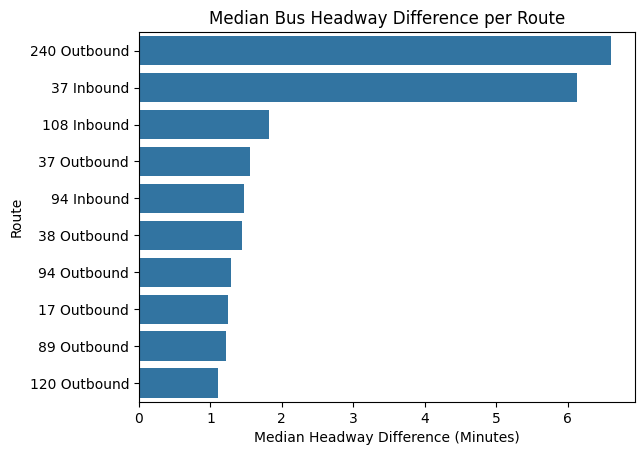

In [26]:
sns.barplot(data = bus_headway_route.head(10), x = 'median', y = 'route_name', orient = 'h')
plt.title('Median Bus Headway Difference per Route')
plt.ylabel('Route')
plt.xlabel('Median Headway Difference (Minutes)')

In [27]:
bus_headway_route_stop = bus_standard_headway.groupby(['route_id', 'direction_id', 'stop_id', 'stop_name', 'stop_lat', 'stop_lon'])['headway_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_headway_route_stop = bus_headway_route_stop.sort_values(by = 'median', ascending = False)
bus_headway_route_stop['route_name'] = 'Route: ' + bus_headway_route_stop['route_id'] + ' ' + bus_headway_route_stop['direction_id'].astype(str) + ' At ' + bus_headway_route_stop['stop_name']
bus_headway_route_stop.head()

,route_id,direction_id,stop_id,stop_name,stop_lat,stop_lon,mean,median,std,max,min,count,route_name
475,37,Inbound,10642,Forest Hills,42.299850,-71.114261,20.328803,25.433333,12.807135,44.616667,0.0,103,Route: 37 Inbound At Forest Hills
353,240,Outbound,4165,N Main St @ Scanlon Dr,42.201227,-71.062850,11.288194,9.483333,11.504215,46.566667,0.0,24,Route: 240 Outbound At N Main St @ Scanlon Dr
476,37,Inbound,636,Washington St @ Cummins Hwy,42.286660,-71.127791,13.512019,8.941667,12.453101,38.383333,0.0,104,Route: 37 Inbound At Washington St @ Cummins Hwy
180,117,Outbound,5790,49 Central Ave,42.409605,-71.010465,10.452703,8.816667,9.574476,51.366667,0.0,74,Route: 117 Outbound At 49 Central Ave
354,240,Outbound,4177,N Main St opp Francis Dr,42.183170,-71.053734,10.974638,8.800000,11.772203,46.316667,0.0,23,Route: 240 Outbound At N Main St opp Francis Dr


Text(0.5, 0, 'Median Headway Difference (Minutes)')

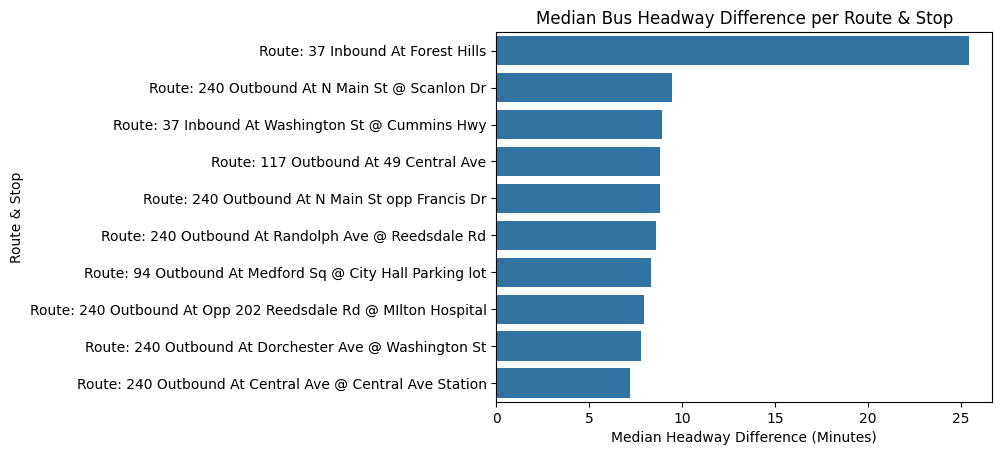

In [28]:
sns.barplot(data = bus_headway_route_stop.head(10), x = 'median', y = 'route_name', orient = 'h')
plt.title('Median Bus Headway Difference per Route & Stop')
plt.ylabel('Route & Stop')
plt.xlabel('Median Headway Difference (Minutes)')

In [29]:
fig = px.scatter_mapbox(bus_headway_route_stop, lat="stop_lat", lon="stop_lon",
                        zoom=10,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station & Route - Headway',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop',
                                  'route_id': 'Route'},
                        hover_data = ['direction_id', 'stop_name', 'route_id'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)

fig.show()

In [30]:
bus_headway_date = bus_standard_headway.groupby(['service_date', 'direction_id'])['headway_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_headway_date = bus_headway_date.sort_values(by = 'median', ascending = False)
bus_headway_date['date_name'] = bus_headway_date['service_date'] + ' ' + bus_headway_date['direction_id'].astype(str)
bus_headway_date.head()

,service_date,direction_id,mean,median,std,max,min,count,date_name
363,2024-06-30,Outbound,2.603455,0.116667,4.708719,48.166667,0.0,9619,2024-06-30 Outbound
194,2024-04-07,Inbound,2.503195,0.116667,4.749136,69.883333,0.0,8137,2024-04-07 Inbound
1,2024-01-01,Outbound,2.041259,0.116667,3.932610,42.450000,0.0,9427,2024-01-01 Outbound
111,2024-02-25,Outbound,2.554259,0.100000,5.736409,69.950000,0.0,9505,2024-02-25 Outbound
69,2024-02-04,Outbound,2.480005,0.083333,5.633836,90.800000,0.0,9514,2024-02-04 Outbound
